# Align the Book and Movie

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio

In [ ]:
import re
import pylcs
import json

In [ ]:
from collections import Counter

In [ ]:
from tqdm import tqdm

In [ ]:
%load_ext autoreload
%autoreload 2

Set the path for the scene break file

In [ ]:
SCENE_BREAK_PATH = "processed/hp/scene_detect_output.mat"

# Utilities

In [ ]:
def savecache(data, name):
    np.save(f"{name}.npy", data)

In [ ]:
def loadcache(name):
    out = np.load(f"{name}.npy", allow_pickle=True)
    if isinstance(out, np.ndarray):
        return out
    else:
        return out.item()

# Load Scene Breaks

In [ ]:
scene_breaks = sio.loadmat(SCENE_BREAK_PATH)['scene_breaks']

In [ ]:
scene_breaks = scene_breaks - 1 # Convert from matlab indexing to python

In [ ]:
scene_breaks = np.array(list(filter(lambda x: x[2], scene_breaks)))
# scene_breaks

array([[   0,    8,    8],
       [   9,   25,   16],
       [  26,   46,   20],
       [  47,   59,   12],
       [  60,   83,   23],
       [  84,  120,   36],
       [ 121,  155,   34],
       [ 156,  169,   13],
       [ 170,  189,   19],
       [ 190,  195,    5],
       [ 196,  214,   18],
       [ 215,  234,   19],
       [ 235,  248,   13],
       [ 249,  281,   32],
       [ 282,  299,   17],
       [ 300,  339,   39],
       [ 340,  354,   14],
       [ 355,  361,    6],
       [ 362,  379,   17],
       [ 380,  386,    6],
       [ 387,  403,   16],
       [ 404,  428,   24],
       [ 429,  451,   22],
       [ 452,  481,   29],
       [ 482,  499,   17],
       [ 500,  523,   23],
       [ 524,  533,    9],
       [ 534,  572,   38],
       [ 573,  592,   19],
       [ 593,  650,   57],
       [ 651,  656,    5],
       [ 657,  663,    6],
       [ 664,  684,   20],
       [ 685,  704,   19],
       [ 705,  737,   32],
       [ 738,  775,   37],
       [ 776,  799,   23],
 

# Load Shot Boundaries and TimeStamps

Set the path to vid events computed earlier

In [ ]:
VIDEVENTS_PATH = "processed/hp/movie.videvents"

In [ ]:
shot_boundaries = pd.read_csv(VIDEVENTS_PATH, sep=' ')

# Convert Scene Break to Time Maps

In [ ]:
start_times = []
end_times = []

In [ ]:
for scene_break in scene_breaks:
    start_shot, end_shot, nshots = scene_break
    
    start_time, end_time = shot_boundaries.iloc[start_shot]['time'], shot_boundaries.iloc[end_shot-1]['time']
    
    start_times.append(start_time)
    end_times.append(end_time)

In [ ]:
scene_break_times = np.hstack([scene_breaks, np.array(start_times).reshape(-1, 1), np.array(end_times).reshape(-1, 1)])

Save to cache: start, end, #scenes, start_time, end_time 

In [ ]:
savecache(scene_break_times, "scene_break_times")

0

# Get All Subtitles Within Range

Set the subtitles and transcript path

In [ ]:
SRT_PATH = "../Soundtracking-Books/data/HP/new_subtitles.srt"
TRANSCRIPT_JSON_PATH = "../Soundtracking-Books/data/HP/new_transcript.json"

In [ ]:
import pysrt

In [ ]:
from pysrt.srttime import SubRipTime

In [ ]:
ALL_SUBS = []

In [ ]:
SUBTITLE = pysrt.open(SRT_PATH)

In [ ]:
f = open(TRANSCRIPT_JSON_PATH, "r")
f = json.load(f)
TRANSCRIPT = f['transcript']

Make a video instance

In [ ]:
from scripts.videoDialogueExtractor import Video

In [ ]:
video = Video(TRANSCRIPT, scene_break_times)

Subtitles within range

In [ ]:
def get_subtitle_characters(start, end):
    matched_subs = []
    for subtitle in TRANSCRIPT:
        
        if subtitle['type']:
            continue
        
        time = subtitle['time']
        time_s = SubRipTime.from_string(subtitle['time'].split("-->")[0])
        time_ms = time_s.ordinal // 1000

        if time_ms >= start and time_ms <= end:
            if 'actor' in subtitle.keys():
                matched_subs.append(subtitle['actor'])
    return matched_subs

In [ ]:
def get_subtitles(start, end):
    matched_subs = []
    for subtitle in TRANSCRIPT:
        
        if subtitle['type']:
            continue

        time = subtitle['time']
        time_s = SubRipTime.from_string(subtitle['time'].split("-->")[0])
        time_ms = time_s.ordinal // 1000
        
#         time_ms = time_s.hour * 60 * 60 + time_s.minute * 60 + time_s.second

        if time_ms >= start and time_ms <= end:
            matched_subs.append(subtitle['line'])
    return matched_subs

# Create Histogram for Movie

In [ ]:
all_movie_chars = []
OTHER_INDEX = -100

for scene in scene_break_times:
    start, end, num, start_time, end_time = scene
    subs = get_subtitle_characters(start_time, end_time)
    
    for sub_char in subs:
        all_movie_chars.append(sub_char.lower())
    
all_movie_chars = list(set(all_movie_chars))
charIndMapping = {char:i for i, char in enumerate(all_movie_chars)}

In [ ]:
print("Characters present:\n", charIndMapping)

{'snape': 0,
 'mrs. weasley': 1,
 'flitwick': 2,
 'fred': 3,
 'hermione': 4,
 'the fat lady': 5,
 'neville longbottom': 6,
 'hagrid': 7,
 'petunia': 8,
 'boy': 9,
 'voldemort': 10,
 'harry': 11,
 'seamus': 12,
 'gryffindors': 13,
 'goblin': 14,
 'griphook': 15,
 'sorting hat': 16,
 'oliver': 17,
 'ron and harry': 18,
 'unseen inhuman voice': 19,
 'ron and seamus': 20,
 'girl': 21,
 'filch': 22,
 'tom': 23,
 'dudley': 24,
 'fred and george': 25,
 'hooch': 26,
 'class': 27,
 'ron': 28,
 'neville': 29,
 'percy': 30,
 'vernon': 31,
 'nick': 32,
 'man in a painting': 33,
 'bloody baron': 34,
 'all': 35,
 'crowd': 36,
 'guard': 37,
 'boy 2': 38,
 'snake': 39,
 'george': 40,
 'flint': 41,
 'mcgonagall': 42,
 'lee': 43,
 'firenze': 44,
 'witch': 45,
 'ginny': 46,
 'dean': 47,
 'ollivander': 48,
 'dumbledore': 49,
 'draco': 50,
 'man': 51,
 'all (including flitwick)': 52,
 'quirrell': 53,
 'students': 54,
 'woman': 55}

In [ ]:
OTHER_INDEX = len(all_movie_chars)

# Uncomment this if you want to include unknown characters
# charIndMapping['other'] = OTHER_INDEX
# all_movie_chars.append('other')

Make default histogram

In [ ]:
scene_char_histograms = []

for scene in scene_break_times:
    start, end, num, start_time, end_time = scene
    subs = get_subtitle_characters(start_time, end_time)    
    
    scene_hist = list(np.zeros(len(all_movie_chars)))
    
    for sub_char in subs:
        scene_hist[charIndMapping[sub_char.lower()]] += 1
    
    scene_char_histograms.append(scene_hist)

# Get All Book Names

In [ ]:
from scripts.characterNameBookParser import getSpeakerChapterNames, getMentionedChapterNames

Set path to the processed book (from `jsonify_book`) and the book text files

In [ ]:
BOOK_PROC_PATH = "../book-process/processed_data/Harry_Potter"
BOOK_TEXT_PATH = "../Soundtracking-Books/data/HP/chapters/"

In [ ]:
chapter_names = os.listdir(BOOK_PROC_PATH)

Get Character Occurence per chapter

In [ ]:
chapterCharacterCount = list(map(lambda x: getSpeakerChapterNames(os.path.join(BOOK_PROC_PATH, x, x)), chapter_names))

Make character list after taking union

In [ ]:
allBookNames = []

for chapCharCount in chapterCharacterCount:
    for key in chapCharCount.keys():
        allBookNames.append(key.lower())
        
allBookNames = list(set(allBookNames))

Match names in book to subtitle names

In [ ]:
bookMovieNameMap = {}

for name in allBookNames:
    maxLCS = 0
    newname = "NONE"
    
    filtered_name = name.replace("professor", '').replace("aunt", '').replace("uncle", '').strip()
    
    for movie_name in all_movie_chars:        
        lcs = pylcs.lcs2(movie_name, filtered_name)
                
        if lcs > maxLCS:
            
            words = list(filter(lambda x: len(x) > 1 and x.isalpha(), movie_name.split()))
            word_length = list(map(lambda x: len(x), words))

            if len(word_length) == 0:
                continue
            
            if lcs not in word_length and not (lcs > np.max(word_length)):
                continue
            
            maxLCS = lcs
            newname = movie_name
            
    if newname == "NONE":
        print(name, "mapped to other")
        bookMovieNameMap[name] = 'other'
    else:
        print(name, "-", newname)
        bookMovieNameMap[name] = newname      

draco malfoy - draco
snape - snape
grunt - man in a painting
mrs. weasley - mrs. weasley
oliver wood - oliver
fred - fred
hermione - hermione
piers polkiss - man in a painting
hagrid - hagrid
fred weasley - mrs. weasley
petunia - petunia
gryffindor keeper wood - man in a painting
dudley dursley - dudley
nicholas flamel dumbledore - dumbledore
harry - harry
ronan - ron and harry
diagon alley harry - ron and harry
griphook - griphook
mrs. dursley mapped to other
wood mapped to other
the gryffindors - gryffindors
professor quirrell - quirrell
mrs. norris mapped to other
sir nicholas de mimsy mapped to other
filch - filch
dudley - dudley
professor flitwick - flitwick
rubeus hagrid - hagrid
ron - ron and harry
malfoy - man in a painting
neville - neville longbottom
professor dumbledore - dumbledore
percy - percy
madam malkin - man in a painting
gryffindor - man in a painting
hufflepuff mapped to other
diggle mapped to other
friar mapped to other
madam pomfrey - fred and george
halloween mal

Manually fix the incorrect ones - change depending on your book

In [ ]:
bookMovieNameMap['ginny weasley'] = 'ginny'
bookMovieNameMap['slytherins'] = 'other'
bookMovieNameMap['madam malkin'] = 'other'
bookMovieNameMap['professor flitwick'] = 'flitwick'
bookMovieNameMap['madam pomfrey'] = 'other'
bookMovieNameMap['bane'] = 'other'
bookMovieNameMap['jordan'] = 'other'
bookMovieNameMap['grunt'] = 'other'
bookMovieNameMap['norbert the norwegian ridgeback quirrell'] = 'other'
bookMovieNameMap['mrs. dursley'] = 'petunia'
bookMovieNameMap['nicholas flamel dumbledore'] = 'other'
bookMovieNameMap['harry potter'] = 'harry'
bookMovieNameMap['george weasley'] = 'george'
bookMovieNameMap['george'] = 'george'
bookMovieNameMap['seamus finnigan'] = 'seamus'
bookMovieNameMap['finnigan'] = 'other'
bookMovieNameMap['harry '] = 'harry'
bookMovieNameMap['malfoy'] = 'draco'
bookMovieNameMap['gryffindor'] = 'other'
bookMovieNameMap['miss granger'] = 'hermione'
bookMovieNameMap['gryffindor keeper wood'] = 'other'

# Create Book Histogram

In [ ]:
book_chap_histograms = []

for chapCharCount in chapterCharacterCount:

    chap_hist = list(np.zeros(len(all_movie_chars)))

    for key in chapCharCount.keys():
        name = key.lower()
        if bookMovieNameMap[name] != 'other':
            chap_hist[charIndMapping[bookMovieNameMap[name]]] += chapCharCount[key]

    book_chap_histograms.append(chap_hist)

In [ ]:
charIndMapping

{'snape': 0,
 'mrs. weasley': 1,
 'flitwick': 2,
 'fred': 3,
 'hermione': 4,
 'the fat lady': 5,
 'neville longbottom': 6,
 'hagrid': 7,
 'petunia': 8,
 'boy': 9,
 'voldemort': 10,
 'harry': 11,
 'seamus': 12,
 'gryffindors': 13,
 'goblin': 14,
 'griphook': 15,
 'sorting hat': 16,
 'oliver': 17,
 'ron and harry': 18,
 'unseen inhuman voice': 19,
 'ron and seamus': 20,
 'girl': 21,
 'filch': 22,
 'tom': 23,
 'dudley': 24,
 'fred and george': 25,
 'hooch': 26,
 'class': 27,
 'ron': 28,
 'neville': 29,
 'percy': 30,
 'vernon': 31,
 'nick': 32,
 'man in a painting': 33,
 'bloody baron': 34,
 'all': 35,
 'crowd': 36,
 'guard': 37,
 'boy 2': 38,
 'snake': 39,
 'george': 40,
 'flint': 41,
 'mcgonagall': 42,
 'lee': 43,
 'firenze': 44,
 'witch': 45,
 'ginny': 46,
 'dean': 47,
 'ollivander': 48,
 'dumbledore': 49,
 'draco': 50,
 'man': 51,
 'all (including flitwick)': 52,
 'quirrell': 53,
 'students': 54,
 'woman': 55}

Use inverse frequency

In [ ]:
book_chap_all = np.sum(book_chap_histograms, 0)
# book_chap_all

array([ 51.,  27.,   7.,   8., 171.,   7.,  34., 301.,  29.,   0.,   3.,
       469.,   4.,   1.,   0.,   4.,   0.,  23., 431.,   0.,   0.,   0.,
        23.,   0.,  29.,   0.,  15.,   0.,   0.,   0.,   3.,  74.,   1.,
         5.,   0.,   5.,   0.,   0.,   0.,   0.,  12.,   0.,  58.,   0.,
        13.,   0.,   4.,   5.,  21.,  99.,  30.,   0.,   1.,  54.,   0.,
         0.])

In [ ]:
itf_character = 1/np.log(book_chap_all)
itf_character[itf_character == np.inf] = 0

/home/jd/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/jd/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
itf_character

array([ 0.25433478,  0.30341308,  0.51389834,  0.48089835,  0.19448958,
        0.51389834,  0.28357849,  0.17522002,  0.2969742 , -0.        ,
        0.91023923,  0.16258569,  0.72134752,  0.        , -0.        ,
        0.72134752, -0.        ,  0.31892899,  0.16485034, -0.        ,
       -0.        , -0.        ,  0.31892899, -0.        ,  0.2969742 ,
       -0.        ,  0.36926937, -0.        , -0.        , -0.        ,
        0.91023923,  0.23233849,  0.        ,  0.62133493, -0.        ,
        0.62133493, -0.        , -0.        , -0.        , -0.        ,
        0.4024296 , -0.        ,  0.24627855, -0.        ,  0.38987125,
       -0.        ,  0.72134752,  0.62133493,  0.32845874,  0.21762218,
        0.2940141 , -0.        ,  0.        ,  0.2506904 , -0.        ,
       -0.        ])

# Compute Similarity Matrix

In [ ]:
import matplotlib.pyplot as plt
from scipy import spatial

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
# np.array(book_chap_histograms[0])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., 24.,  0.,  0.,  0.,  0.,  0.,  0., 31.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [ ]:
# book_chap_histograms[0] * itf_character

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.87610012,  1.48487102, -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        ,  5.9106851 , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  6.74628759,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ])

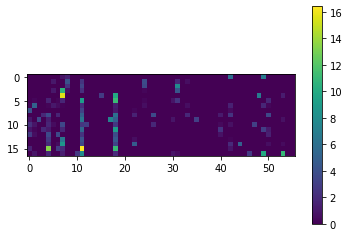

In [ ]:
plt.imshow(book_chap_histograms * itf_character)
plt.colorbar()

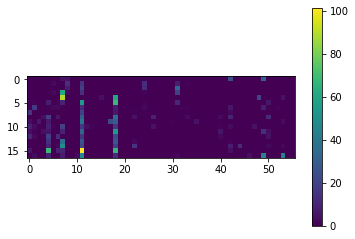

In [ ]:
plt.imshow(book_chap_histograms)
plt.colorbar()

In [ ]:
CHAP_COUNT = len(book_chap_histograms)
SCENE_COUNT = len(scene_char_histograms)

characterSimMat = np.zeros((CHAP_COUNT, SCENE_COUNT))

norm_book_chap_histograms = normalize(book_chap_histograms, axis=1, norm='l2')
norm_scene_char_histograms = normalize(scene_char_histograms, axis=1, norm='l2')

for i in range(CHAP_COUNT):
    for j in range(SCENE_COUNT):
        
        characterSimMat[i][j] = (2 ** 0.5) - np.linalg.norm(norm_scene_char_histograms[j] - norm_book_chap_histograms[i])
#         characterSimMat[i][j] = 1 - spatial.distance.cosine(norm_book_chap_histograms[i], norm_scene_char_histograms[j])
    
        if np.isnan(characterSimMat[i][j]):
            characterSimMat[i][j] = 0

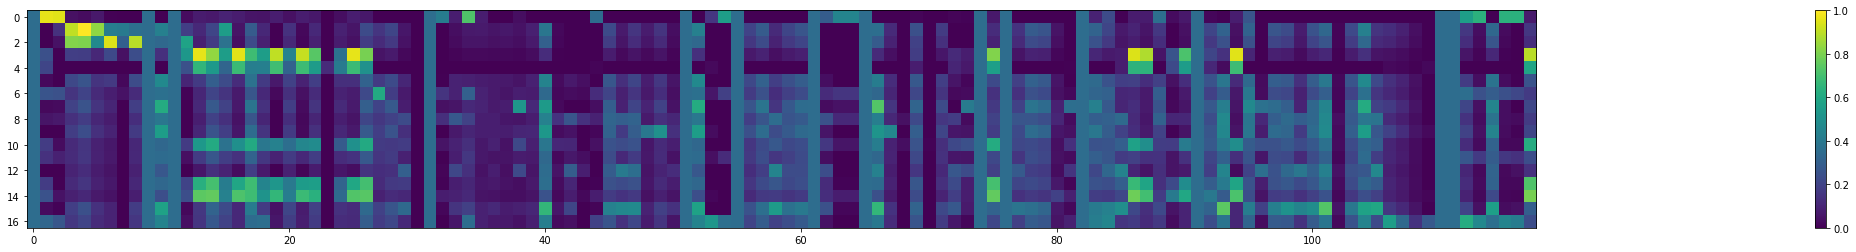

In [ ]:
plt.imshow(characterSimMat/np.max(characterSimMat.flatten()))
plt.colorbar()
plt.gcf().set_figwidth(100)
plt.show()

In [ ]:
normCharacterSimMat = characterSimMat/np.max(characterSimMat.flatten())

In [ ]:
savecache(characterSimMat, 'characterSimMat_120_axis0')

0

In [ ]:
characterSimMat = loadcache('characterSimMat_120_axis0')

# Next Part: Dialogue Matching 

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
from scripts.bookQuoteExtractor import Book, getChapterQuotes

In [ ]:
chapters = sorted(os.listdir(BOOK_TEXT_PATH), key=lambda x: int(x.split('-')[0]))

Create book class

In [ ]:
book = Book(chapters, BOOK_TEXT_PATH)

In [ ]:
chapterText = book.chapterContent
chapterText = list(map(lambda x: x.getText(), chapterText))

Get all subtitles / dialogues in movie

In [ ]:
sceneText = []

for scene in scene_break_times:
    start, end, num, start_time, end_time = scene
    subs = get_subtitles(start_time, end_time)
    
    sceneText.append(subs)

In [1269]:
from scripts.lcs import lcs

In [1270]:
from scripts.utils import *

Compute Term Frequency for all words in video

In [ ]:
f = open(TRANSCRIPT_JSON_PATH, "r")
subtitles = json.load(f)
subtitles = subtitles['transcript']

videoTextAll = ' '.join(list(map(lambda x: x['line'], subtitles))).lower()
videoTextWords = list(map(lambda x: remove_punctuation(remove_extra_whitespace(x)), videoTextAll.split()))
videoWordCount = dict(Counter(videoTextWords))

NameError: name 'remove_punctuation' is not defined

Compute term frequency for all words in book

In [ ]:
bookText = book.getAllText().lower()

In [ ]:
bookWords = list(map(lambda x: remove_punctuation(remove_extra_whitespace(x)), bookText.split()))
bookWordCount = dict(Counter(bookWords))

Go Through every chapter, get all dialogues in the chapter, and compute the score

In [1271]:
chapterQuotes = list(map(lambda x: getChapterQuotes(os.path.join(BOOK_TEXT_PATH, x + ".txt")), chapter_names))

In [1272]:
videoDialogues = list(map(lambda x: video.get_subtitles_in_scene(x), np.arange(len(video))))

In [1273]:
def text_process_dialogue(sent):
    sent = lower_text(sent)
    sent = remove_extra_whitespace(sent)
    sent = remove_punctuation(sent)
    sent = word_tokenize(sent)
    
    return sent
    
def text_process_dialogues(sents):
    return list(map(text_process_dialogue, sents))

In [1274]:
chapterQuotes = list(map(lambda x: text_process_dialogues(x), chapterQuotes))
videoDialogues = list(map(lambda x: text_process_dialogues(x), videoDialogues))

In [1275]:
from multiprocessing import Pool

In [1284]:
pool = Pool(10)

00  Chapter2 Chapter  2051 Chapter   SceneChapterScene 70 Done: Done: 3  Scene119  00  
ChapterDone:
SceneChapter--------   --------154 

5.66642668811243235
Done:  03Chapter  Scene--------  Scene 20.945815724076905Chapter
86  Done:
 ChapterDone:  --------52  Scene11.90104093474328
  351.36981634154611105
SceneDone: 
2 -------- Scene -------- 
 Chapter
Done:Chapter93.8110029058255 Done:3  
 32 071-------- 
 Chapter 145.4316685127715Scene
Chapter Scene
--------  Done: --------
5520  Done:
 131.96945930351913Scene 19.36293747049243Scene 1
 0Done: --------
Done: Chapter 
Chapter--------  0 
13.631972261242424361

 -------- 1--------SceneScene
  
 02ChapterDone:Done:   87  Chapter61.784885534746586493.7964153945328 ChapterScene 

  72Done:1020----------------   

61.252449081784725 SceneScene
  Chapter--------Done:Done:
   23282.7667268376815539.903087472514787  1
  
ChapterChapter--------ChapterScene-------- 
   5621
37Done:    SceneSceneScene49.72998250064301  1 
Done:Done: --------Done:

  216 12 Chapter Scene Scene 111 Done: Done:  Scene18.37491325938064811.326668173322627 1
2 Done:
3---------------- Chapter  

0Chapter Chapter
 83 --------160 25
 Scene  Scene ChapterScene Done:  Done: Done:17279.6409536419575  
 44.89085923217221--------602.9284957324912
Scene

-------- --------Done:
2 
211.503874629449811  
ChapterChapter--------  
213 61  ChapterSceneScene  112  Done:Done:Scene   25.6258082907833970Done:

-------- --------

11.034115170636251
 --------Chapter
 18 2Scene Chapter Done:  62279.14628281041654  
Scene--------Chapter 
 114Chapter  Done: Chapter117Scene   1 840Scene37.36293164272563   Done: 
ChapterScene2Chapter--------Done:     19
56.68494160007229 25Chapter Done:397.5455251066972 
3 Scene 
-------- Scene113137.2722031090538 
--------Chapter  Done:
 Done:
Scene26  4--------  19.28489482206154621.90359869683862 
Scene
Done:
Chapter -------- --------  ChapterDone:
81.83588484115013
0 
  630211.4145299161417--------Scene 

  Scene--------Done:Chapter
   1Do

Chapter 48 Scene 4Done:7 Chapter 7  Chapter4 Chapter5  28Chapter  Scene42  Done:Scene  512.9945235857545Done:
 --------268.4149442286386

--------  
643  SceneScene  Done:Done:  438.32028132026729166.9922810803788

 98.78099128987473Chapter--------
--------

 --------
--------
1154
6   SceneChapter6Chapter    Done:65Chapter534    227.42599985045882 78SceneSceneChapter
   -------- SceneDone:Done:
5 Chapter 94 Scene Done: 317.5651226945986
7-------- 
Chapter 43 49Scene  Scene Done:Done: 35.47378818108117   4
432.45578117473105Done:0 --------
 Chapter 
ChapterChapter
----------------92.9132171278804 
  

1169429 --------  Scene 
SceneScene302.8130895479072 7  Done:Done: 
Done:Chapter    --------418.8722562698510536.864272107837681408.07791044247784



 ------------------------Scene

 
Done:476    7ChapterChapter46.89739461900022Chapter    Chapter
79 5030-------- 95 
 Scene SceneScene Scene5   Done: Done:Done:Done: Chapter   100.25039252447141 658.7862277294869186.910130595785720
95  


--

    117 ChapterScene64Scene    Scene16 Scene Done:Done:    Done:SceneDone:131.63183372584925100.91042791193702   

671.0479245222687Done:--------127.983782808476049--------

  

--------51.33977538638295Chapter--------

--------
 6113
10 9   ChapterScene8Chapter8 Chapter 41 Scene Done: 798.2222932818296
--------
 Chapter8  Chapter86  14Scene  Done:Scene  Done:355.00981360356354
 10  -------- 255.15365376738768Done:0
Chapter
    --------169.32034138221948Chapter967Scene
45    
 Chapter65--------SceneDone: Scene90 
   SceneDone: Done:0  Scene 9
Done:71.79282066002324  --------231.64095096746803
Done:Chapter
 
--------  --------0
113.83271138491784179


8  ----------------Scene Chapter

 Chapter 7 114 Done:42 Chapter  Scene31.269369626056434 
Scene91 --------Done:
  10 SceneDone: 17.045246082262896  Chapter
273.18688551949504Done: -------- 
460
-------- 

6--------Scene Chapter
  Done:1  31.495813507893857Scene
8 --------Done: 
Chapter 76.56393585510929 
43 --------Scene
 Done: 35.2553275

Done:   Done:  --------Chapter 112Scene18.161314980484125441.305940546131
  256.74102030262986 1012


Scene97Done:  ------------------------  Chapter Chapter


 Scene 24.07225593508122Done:1229 64
   Done: 129.0640913434184--------ChapterScene
 
Scene  --------298.986682085665311Done: 30
 
 Done: --------486.30712517627745ChapterScene 

  34.923897635486995--------55Done:

  --------9Scene100 
 
 Chapter12Done:Chapter--------    
046Chapter3012
   -------- Scene65Scene
 Chapter  Done: Done:Scene  31 030.707356147529588 Done:11 

 SceneChapter--------0 -------- 11

Done:
 13-------- Chapter 10110 
Scene 9 
100Chapter Chapter --------  Done: 
Chapter3156Scene     166.28389215103178Scene98
Done:Scene  --------  SceneDone:
Done: 506.5414597510320510  0 
Done:114.94193885154357--------Chapter
 
 
--------52.16441797068307--------86


 Scene--------
11 11  Done:Chapter Chapter 395.8989636167899 101
57 -------- 8Scene 
Scene Chapter  Done:Done:12113  18.818137067186566 
98.51817228281985Chapt

 
14SceneChapter13--------    Chapter
 ChapterDone:44 11  822 Scene170.88127582926396 Chapter
  Scene Done:Scene--------76
    Done:Done:101.99797125266144 Scene
 -------- 0205.54129220332862Done:


 12----------------11130
  
 Chapter
Chapter--------Chapter  
 14508422   ChapterScene Scene13    SceneDone:Done:Chapter32     Done:565.5536501383244325.53443026754036100Scene
 
 252.1174461950616-------- --------Scene

 Done:
13-------- Done: 
 255.17749875395947Chapter
392.55512752519405 --------
51
-------- 
1113Scene   Done:ChapterChapter 0  
3116--------11 
  SceneChapter13Scene 13  77  Done:Done:Chapter Chapter  Scene 63.44570588526787 130.27239357753092 52
101Done:
  ---------------- SceneScene

255.41719098238585  
Done:Done:--------  12
9.1902397002691837.4581682784348 12

Chapter --------Chapter-------- 
 
8545 Scene Scene  Done:11 Done: 226.7491072367107613 
 --------ChapterChapter238.39488003207646 
 
--------2353  
11SceneScene Chapter Done:  78 Done: 226.48424739066218 Scene
 

Scene143.24153992694048 Chapter Done:
269.6867439675507 
 --------92--------132.43777159932856
 

Scene-------- Done:
 16308.1533913154063414 
--------Chapter 
 Chapter18  63Scene Done: 16563.96676392347115 
 --------ChapterChapter 
69 88  SceneScene  Done:Done:  122.06644072735993280.38983875881877

 ----------------Scene

 Done: 139.80450913369694
--------
16 Chapter16 70  ChapterScene13  19  Done:SceneChapter   47.8457339784975359316Done:
   135.37645893378894Chapter--------Scene
 
 --------106Done: 
 Scene465.1963178527211
 --------14Done:
14   Chapter1134.2023197684593Chapter 
 1564--------  
SceneScene  Done: Done:603.7669031397097
 --------108.04157154266942

--------
1416  ChapterChapter  14 6571Chapter  Scene Scene 106 Done: Done:  Scene 049.5109043395319513Done:

  ----------------Chapter534.0532220232798


 94-------- 
Scene Done:14 225.400753785922216 Chapter
 Chapter-------- 16 
20  SceneScene  Done:Done:  108.74001707710815163.8632336118608

----------------

16 Chapter 1

Process ForkPoolWorker-160:
Process ForkPoolWorker-162:
Process ForkPoolWorker-158:
Process ForkPoolWorker-161:
Process ForkPoolWorker-157:
Process ForkPoolWorker-155:
Process ForkPoolWorker-163:
Process ForkPoolWorker-154:
Process ForkPoolWorker-156:
Process ForkPoolWorker-159:
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/music/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jd/anaconda3/envs/music/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jd/anaconda3/envs/music/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/jd/anaconda3/envs/music/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/jd/anaconda3/envs/music/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent cal

In [1285]:
dialogueSimMat = np.zeros((CHAP_COUNT, SCENE_COUNT))

Get stopwords

In [1286]:
import nltk
from nltk.corpus import stopwords

STOPWORDS = stopwords.words('english')

In [1287]:
def simMake(i, j):        
    itf = 0
    scores = []
    dialogues = []
    
    for ii in range(len(chapterQuotes[i])):
        for jj in range(len(videoDialogues[j])):

            matched = lcs(chapterQuotes[i][ii], videoDialogues[j][jj])
            matched = list(filter(lambda x: x not in STOPWORDS, matched))
            
            localItf = 0
            
            for word in matched:
                if word in videoWordCount.keys():
                    localItf += np.log(1/videoWordCount[word])
                else:
                    print(word, "missing")
                    
            scores.append(localItf * len(matched))
            dialogues.append(matched)
            
            itf += localItf * len(matched)
    
    dialogueSimMat[i, j] = itf
    
    print(i, "Chapter", j, "Scene", "Done:", -itf)    
    print("--------")
    
    return itf

In [1288]:
iterables = []

for i in range(CHAP_COUNT):
    for j in range(SCENE_COUNT):
        iterables.append((i, j))

In [1289]:
result = pool.starmap(simMake, iterables)

In [1290]:
for idx, iterable in enumerate(iterables):
    i, j = iterable
    dialogueSimMat[i][j] = result[idx]

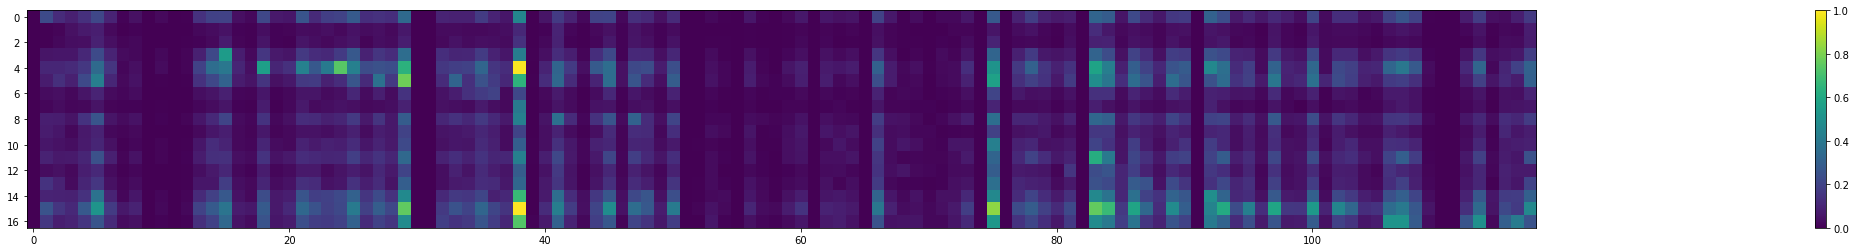

In [67]:
plt.imshow(-dialogueSimMatLoad/np.max(-dialogueSimMatLoad))
plt.colorbar()
plt.gcf().set_figwidth(100)
plt.show()

Normed Similarity Matrix for Dialogue

In [1509]:
normedDialogueSimMat = -dialogueSimMat/np.max(-dialogueSimMat)

In [1510]:
savecache(dialogueSimMat, 'dialogueMatch_120')

0

In [1511]:
savecache(normedDialogueSimMat, 'normedDialogueSimMat_120')

0

In [66]:
dialogueSimMatLoad = loadcache('dialogueMatch_120')
normedDialogueSimMat = loadcache('normedDialogueSimMat_120')

# Create Graph

In [70]:
import igraph

In [71]:
G = igraph.Graph(directed=True)

In [72]:
NC = CHAP_COUNT
NS = SCENE_COUNT
S_vertex = NC * NS
T_vertex = NC * NS + 1

In [74]:
"""
Since igraph only supports integer indexing, we convert pixel coordinates to integer.
"""
def tuple_to_int(i, j, col):
    return i * col + j

In [75]:
"""
This converts hashed nodes back to the pixel coordinates.
"""
def int_to_tuple(pt, col):
    y = pt % col
    x = (pt - y)/col
    return (x, y)    

## Make Vertices

In [76]:
vertices = [S_vertex, T_vertex]
_ = [[vertices.append(tuple_to_int(i, j, NS)) for j in range(NS)] for i in range(NC)]
min(vertices), max(vertices)

(0, 2007)

## Make Edges

In [77]:
edges = []
capacity = []

In [78]:
alpha = 1
gs = []

Add edges from source

In [79]:
for i in range(NC):
    gaussian_factor = 2 - np.exp(-(i) ** 2/(2*NS**2)) # Equation 7 (Global)
    
#     print(gaussian_factor, S_vertex, tuple_to_int(i, 0, NS))
    
    edges.append([S_vertex, tuple_to_int(i, 0, NS)])
    capacity.append(gaussian_factor)

Add edges to sink

In [80]:
for i in range(NC):
    gaussian_factor = 2 - np.exp(-(NC-i-1) ** 2/(2*NS**2)) # Equation 7 (Global)  
    
#     print(gaussian_factor, tuple_to_int(i, NS-1, NS), T_vertex)
    
    if i == NC-1:
        gaussian_factor = 0
    
    edges.append([tuple_to_int(i, NS-1, NS), T_vertex])
    capacity.append(gaussian_factor)

In [81]:
np.min(capacity), np.max(capacity)

(0.0, 1.0091506364544904)

Add edge from scene s to scene s+1 for all chapters - local distance - Includes global likelihood

Also subtract the similarity values based on character histograms and 

**This is not done for the first row - no chapter**

In [82]:
edgeWeightMat = np.zeros_like(normCharacterSimMat)

In [83]:
for j in range(NS-1): # Cannot do the last column / scene
    for i in range(NC):  # For every chapter
        for k in range(NC): # For every next chapter             
            
            if k < i or k > i+1: # FORCE all chapters to only jump to next, not further
                continue
            
            weight = alpha + ((k-i)**2/(2 * NC**2)) # Equation 6 (Local)
            gaussian_factor = 2 - np.exp(-(j - i*(NS/NC)) ** 2/(2*NS**2)) # Equation 7 (Global)
                        
            weight *= gaussian_factor
            gs.append(gaussian_factor)
                        
            weight -= 0.5 * normCharacterSimMat[k, j+1]
            weight -= 0.5 * normedDialogueSimMat[k, j+1]

#             print(weight, i, j, "->", k, j+1)
                        
            if weight < 0:
                print(weight)
                weight = 0

#             weight *= gaussian_factor
                        
            edgeWeightMat[k, j+1] = weight
            edges.append([tuple_to_int(i, j, NS), tuple_to_int(k, j+1, NS)])
            capacity.append(weight)

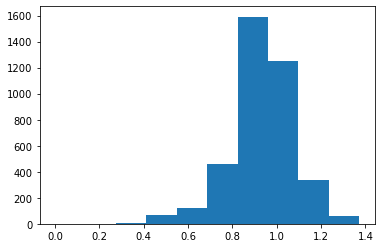

In [84]:
plt.hist(capacity)
plt.show()

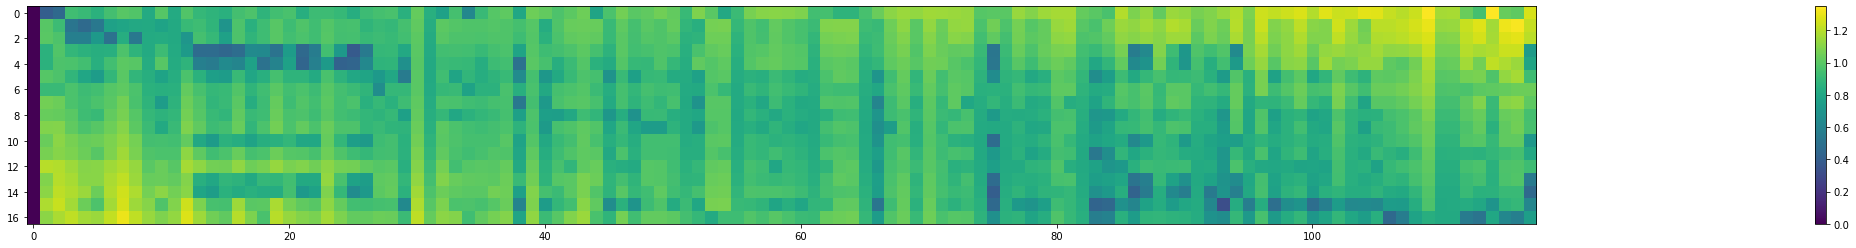

In [85]:
plt.imshow(edgeWeightMat)
plt.colorbar()
plt.gcf().set_figwidth(100)
plt.show()

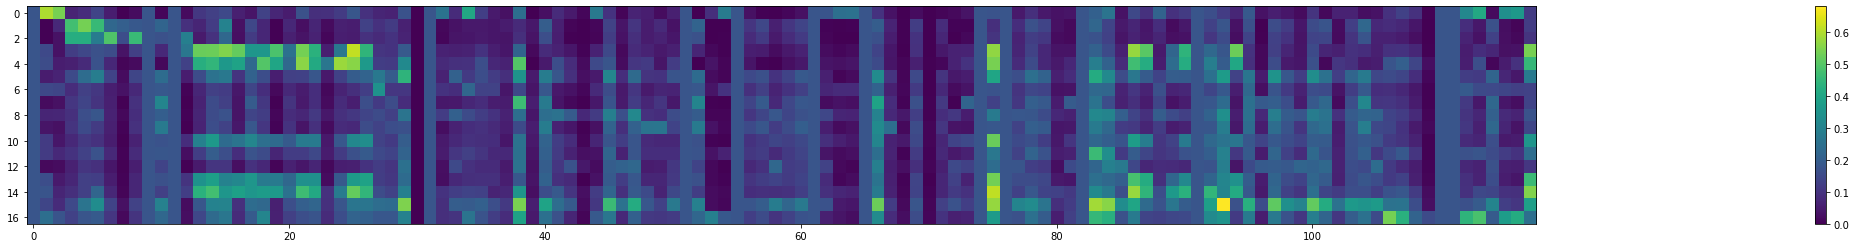

In [86]:
plt.imshow(0.5 * normCharacterSimMat + 0.5 * normedDialogueSimMat)
plt.colorbar()
plt.gcf().set_figwidth(100)
plt.show()

In [87]:
mu_g = np.mean(gs)

# Add Things to the Graph

In [92]:
G.add_vertices(vertices)
G.add_edges(edges, {'capacity': capacity})

# Compute Shortest Path

In [106]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 15,
})

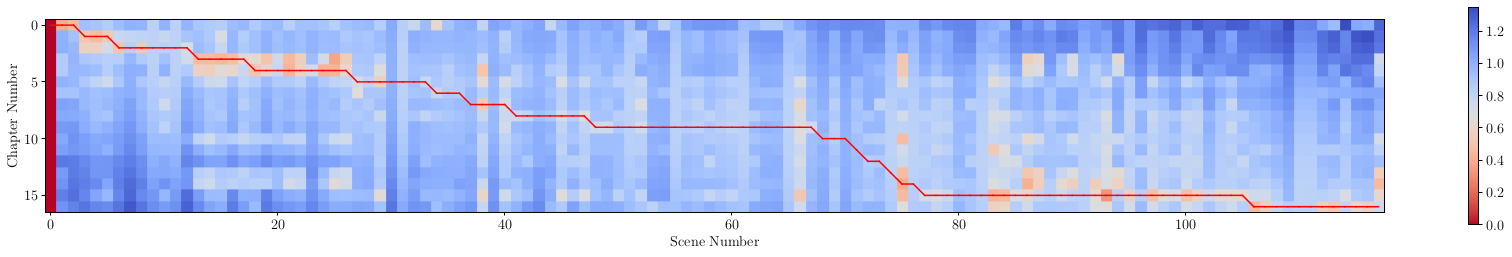

In [109]:
path = G.get_shortest_paths(S_vertex, to=T_vertex, weights=capacity, mode="out", output='vpath')[0][1:-1]
alignment = []

plt.imshow(edgeWeightMat, cmap='coolwarm_r')
prevI = 0
prevJ = 0

for node in path:
    chap, scene = int_to_tuple(node, NS)
    
    alignment.append({
        'chapter': chap,
        'scene': scene
    })
    
    plt.plot([prevJ, scene], [prevI, chap], color="red")
    
    prevI = chap
    prevJ = scene
    
    
plt.colorbar()
plt.gca().set_ylabel("Chapter Number")
plt.gca().set_xlabel("Scene Number")
plt.gcf().set_figwidth(30)
# plt.savefig("graph_b2m.pdf", bbox_inches="tight")
plt.show()

Save to cache

In [207]:
savecache(alignment, 'alignment')

0